This notebook calculates the average effective velocity of the same ion. Link to [Figure 6](#figure6).

(The internal hyperlink only works on [nbviewer](https://nbviewer.org). Do not click when viewing the notebook on GitHub.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import cmcrameri as cmcm
import juanfit

In [29]:
df = pd.read_excel("../../save/eis_line_list_final_v2.xlsx",sheet_name="resolve")
df["ion"] = df["ion"].str.strip()
df["charge_stat"] = df["charge_stat"].str.strip()
df["quality"] = df["quality"].str.strip()
df["fwhm_true_err"] = df["fwhm_fit"]/df["fwhm_true"]*df["fwhm_err"]
df

,ion,charge_stat,Z,A,temp,wvl_fit,wvl_chianti,fwhm_fit,fwhm_err,fwhm_true,fwhm_awsom_fit,fwhm_awsom_err,fwhm_awsom_true,quality,desc,fwhm_true_cross,fwhm_true_err
0,Fe,x,9,55.85000,5.9,174.521,174.531,0.07940,0.00150,0.0380,0.082,0.000030,0.0434,a,NaN,0.047998,0.003134
1,Fe,ix,8,55.85000,5.8,176.971,176.945,0.06490,0.00480,NaN,0.081,0.000800,0.0414,c,NaN,0.014541,NaN
2,Fe,x,9,55.85000,5.9,177.230,177.240,0.08077,0.00064,0.0407,0.083,0.000200,0.0440,a,NaN,0.050232,0.001270
3,Fe,xi,10,55.85000,6.0,182.163,182.167,0.08020,0.00150,0.0396,0.086,0.000100,0.0503,a,NaN,0.049310,0.003038
4,Fe,x,9,55.85000,5.9,182.304,182.307,0.08560,0.00270,0.0496,0.082,0.000500,0.0423,b,NaN,0.057678,0.004660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Mg,vii,6,24.30500,5.8,280.727,280.742,0.07790,0.00730,0.0358,0.097,0.000008,0.0676,b,NaN,0.045474,0.015885
80,Al,ix,8,26.98154,5.9,282.415,282.422,0.09300,0.01600,0.0629,0.103,0.000080,0.0755,b,NaN,0.068179,0.023657
81,Al,ix,8,26.98154,5.9,284.032,284.042,0.09120,0.00760,0.0594,0.113,0.001000,0.0882,b,NaN,0.065703,0.011669
82,Fe,xv,14,55.85000,6.2,284.161,284.163,0.05600,0.00870,NaN,0.094,0.002000,0.0623,c,sim too hot,NaN,NaN


In [32]:
for index,row in df.iterrows():
    print(row["ion"],row["charge_stat"],row["wvl_chianti"],"{:.1f} {:#.2g}".format(row["fwhm_true"]*1e3,row["fwhm_true_err"]*1e3),
    row["fwhm_fit"]*1e3,row["fwhm_err"]*1e3)

Fe x 174.531 38.0 3.1 79.39999999999999 1.5
Fe ix 176.945 nan nan 64.9 4.8
Fe x 177.24 40.7 1.3 80.77 0.64
Fe xi 182.167 39.6 3.0 80.19999999999999 1.5
Fe x 182.307 49.6 4.7 85.6 2.7
O vi 183.937 67.8 4.4 97.3 3.1
O vi 184.117 41.5 2.3 81.10000000000001 1.2
Fe x 184.537 37.1 0.55 79.0 0.25999999999999995
Fe viii 185.213 31.4 1.1 76.48 0.45
Mn viii 185.463 44.7 7.2 82.8 3.9
Fe viii 186.598 38.8 1.5 79.79 0.71
Fe viii 187.24 68.2 7.3 97.5 5.1000000000000005
Fe xi 188.216 39.9 0.68 80.33999999999999 0.34
Fe xi 188.299 39.9 0.68 80.33999999999999 0.34
Fe xi 188.997 50.5 34. 86.0 20.0
Fe ix 189.572 19.8 36. 72.0 10.0
Fe xi 189.711 49.7 21. 86.0 12.0
Fe ix 189.935 27.9 1.3 75.1 0.49
Fe x 190.037 39.8 0.97 80.27 0.48000000000000004
Fe xi 190.382 54.7 15. 88.6 9.1
Fe ix 191.206 33.1 4.2 77.10000000000001 1.8
Mn ix 191.635 56.9 6.3 90.0 4.0
Fe xii 192.394 41.9 4.7 81.3 2.4
Fe xi 192.627 42.7 3.1 81.69999999999999 1.6
Fe xii 193.509 40.4 1.0 80.57000000000001 0.5199999999999999
Fe x 193.715 34.6

In [4]:
df_test = df.loc[(df["ion"] == "Fe") & (df["charge_stat"] == "xi") & (df["quality"] == "a")]

In [5]:
def aver_err(data,err,thresh=1.e-5,iter_max=1000):
    sigma_sq = np.var(data)
    n_data = len(data)

    if type(data) is list:
        data = np.array(data)
    if type(err) is list:
        err = np.array(err)

    err_sq_mean = np.mean(np.square(err)) 
    for ii in range(iter_max):
        weight = 1./(sigma_sq + err**2)
        weight = weight/np.sum(weight)
        aver_new = np.sum(weight*data)
        sigma_new_sq = np.max([0.,n_data/(n_data - 1.)*np.sum(weight*np.square(data-aver_new)) - \
                                err_sq_mean])
        
        #print(aver_new,sigma_new_sq)
        if ((sigma_new_sq <= sigma_sq*(1+thresh)) and (sigma_sq <= sigma_new_sq*(1+thresh))):
            break
        else:
            sigma_sq = sigma_new_sq
        
    # if sigma_new_sq == 0:
    #     print("sigma_new is 0.")

    sigma_tot = np.sqrt(1./np.sum(1./(sigma_new_sq + err**2)))
    return aver_new, sigma_tot, sigma_new_sq

# print(aver_err([10,12,7,8],[0.8,1.2,0.5,1.5]))

# aver_bootstrap = np.zeros(5000)
# for ii in range(5000):
#     data = np.random.normal(9.1673963016428,np.sqrt(3.8011034789338853),4)
#     epsilon = np.random.normal(0,[0.8,1.2,0.5,1.5])
#     data_gen = data + epsilon
#     aver_bootstrap[ii], _, _ = aver_err(data_gen,[0.8,1.2,0.5,1.5]) 

# print(np.percentile(aver_bootstrap,[2.5,50,97.5]))

In [6]:
def plot_eis_awsom_width(df,ion,charge=None,quality="a",plot_awsom=False,plot_mle=False,print_df=True,
                        print_veff=False,save_fig=False,save_fname=None,bootstrap=True):
    c = const.c.cgs/1.e5

    if type(ion) is str:
        ion = [ion]
    if type(charge) is str:
        charge = [charge]
    if type(quality) is str:
        quality = [quality]
    
    if charge is None:
        df_plot = df[(df["ion"].isin(ion)) & (df["quality"].isin(quality))].copy()
    else:
        df_plot = df[(df["ion"].isin(ion)) & (df["charge_stat"].isin(charge)) \
                    & (df["quality"].isin(quality))].copy()

    line_name = df_plot["ion"] + r" \textsc{"+ df_plot["charge_stat"] + r"} " + \
         ((df_plot["wvl_chianti"].values).astype("int")).astype("str")

    eis_veff = df_plot["fwhm_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    awsom_veff = df_plot["fwhm_awsom_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    eis_veff_err = df_plot["fwhm_err"]*df_plot["fwhm_fit"] \
                    /df_plot["fwhm_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    awsom_veff_err = df_plot["fwhm_awsom_err"]*df_plot["fwhm_awsom_fit"] \
                    /df_plot["fwhm_awsom_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    df_plot["eis_veff"] = eis_veff
    df_plot["awsom_veff"] = awsom_veff
    df_plot["eis_veff_err"] = eis_veff_err
    
    n_lines = len(df_plot.index)
    plot_x = np.arange(n_lines)

    fig, ax = plt.subplots(figsize=(n_lines*1.2+2,6),constrained_layout=True)

    if plot_mle is True:
        best_est,err_tot, err_est_sq = aver_err(eis_veff,eis_veff_err)
        best_low1sig,best_up1sig = best_est - err_tot, best_est + err_tot
        best_low3sig,best_up3sig = best_est - 3*err_tot, best_est + 3*err_tot
        aver_bootstrap = np.zeros(10000)
        if bootstrap is True:
            for ii in range(10000):
                data = np.random.normal(best_est,np.sqrt(err_est_sq),len(eis_veff))
                epsilon = np.random.normal(0,eis_veff_err)
                data_gen = data + epsilon
                aver_bootstrap[ii], _, _ = aver_err(data_gen,eis_veff_err) 
            best_low3sig,best_low1sig,best_est,best_up1sig,best_up1sigbest_up3sig = \
                np.percentile(aver_bootstrap,[0.15,16,50,84,99.85])



        ax.axhspan(best_low1sig,best_up1sig,color="#FAD689",alpha=0.9)
        ax.axhspan(best_low3sig,best_up3sig,color="#FAD689",alpha=0.5)
        ax.axhline(best_est,color="#FFB11B",lw=2,ls="--",label=r"$\boldsymbol{\bar{v}_{\rm eff}}$")
    
    if plot_awsom:
        ax.errorbar(plot_x,awsom_veff,awsom_veff_err,color="#0089A7",ls="none",marker="d",
                    markersize=6,capsize=5,lw=2,label="AWSoM",zorder=15)
    ax.errorbar(plot_x,eis_veff,eis_veff_err,color="#CC543A",ls="none",marker="o",
                markersize=15,capsize=5,lw=2.5,label=r"\textbf{EIS}",markeredgecolor='white',
            markeredgewidth=2,alpha=0.9,capthick=2.5)


    # ax.scatter(plot_x,awsom_veff,color="#0089A7",marker="o",
    #             lw=3,label="AWSoM",zorder=14)


    ax.set_xlim(left=-1,right=len(line_name))
    ax.set_xticks(plot_x)
    ax.set_xticklabels(line_name)
    ax.tick_params(labelsize=16)
    ax.set_xlabel(r"\textbf{Line}",fontsize=16)
    ax.set_ylabel(r"\textbf{Effective Velocity} $\boldsymbol{v_{\rm eff}\,\left[\mathrm{km\,s^{-1}} \right]}$",
                    fontsize=16)

    if charge is not None:
        title = r"\textbf{" + ion[0] + ' '.join([r" \textsc{" + charge_ +r"} " for charge_ in charge]) + \
                r"}"
    else:
        title = r"\textbf{" + ion[0] + r"}"

    if (plot_mle is True) and (bootstrap is False):
        title = title + r" $\boldsymbol{{\bar{{v}}_{{\rm eff}} = {{{:.1f}}}\pm{{{:.1f}}}\,\left[\mathrm{{km\,s^{{-1}}}}\right]}}$".format(best_est,err_tot)
    elif (plot_mle is True) and (bootstrap is True):
        title = title + \
        r" $\boldsymbol{{\bar{{v}}_{{\rm eff}} = {{{:.1f}}}_{{-{:.1f}}}^{{+{:.1f}}}\,\left[\mathrm{{km\,s^{{-1}}}}\right]}}$". \
            format(best_est,best_est-best_low1sig,best_up1sig-best_est)
    ax.set_title(title,fontsize=18,pad=10)
    ax.tick_params(which="major",width=1.2,length=8,direction="in")
    ax.tick_params(which="minor",width=1.2,length=4,direction="in")
    ax.grid("on")
    ax.legend(loc = 'lower left',fontsize = 18,frameon=False,handlelength=1)

    if print_df:
        print(df_plot)

    if print_veff:
        print(eis_veff)
        print(eis_veff_err)

    if save_fig:
        plt.savefig(fname=save_fname,format=save_fname[-3:])

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
32  Fe         vii  6  55.85   5.7  196.206      196.213      0.08     0.012   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
32     0.0388           0.083           0.001           0.0449       b  NaN   

    fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  eis_veff_err  
32         0.048984       0.024742  35.602617   41.199936     22.703338  
32    35.602617
dtype: float64
32    22.703338
dtype: float64


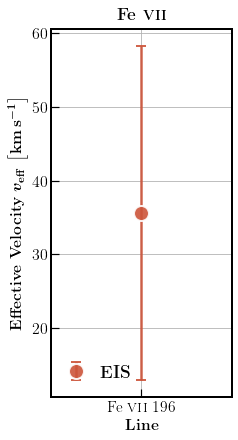

In [7]:
plot_eis_awsom_width(df,"Fe","vii",quality=["a","b"],print_veff=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
8   Fe        viii  7  55.85   5.8  185.209      185.213   0.07648   0.00045   
10  Fe        viii  7  55.85   5.8  186.600      186.598   0.07979   0.00071   
28  Fe        viii  7  55.85   5.8  194.656      194.661   0.07716   0.00049   
51  Fe        viii  7  55.85   5.8  253.947      253.956   0.07980   0.00280   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
8      0.0314           0.082         0.00002           0.0418       a   
10     0.0388           0.082         0.00004           0.0432       a   
28     0.0331           0.083         0.00007           0.0453       a   
51     0.0396           0.091         0.00020           0.0575       a   

                 desc  fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  \
8                 NaN         0.042996       0.001096  30.523628   40.633365   
10                NaN         0.048640       0.001460  37.437145   4

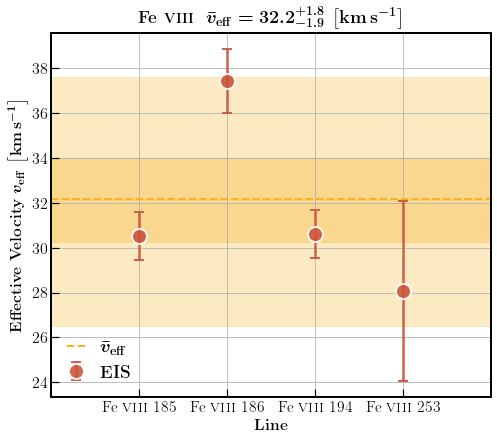

In [8]:
plot_eis_awsom_width(df,"Fe","viii",quality=["a"],plot_mle=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
8   Fe        viii  7  55.85   5.8  185.209      185.213   0.07648   0.00045   
10  Fe        viii  7  55.85   5.8  186.600      186.598   0.07979   0.00071   
11  Fe        viii  7  55.85   5.8  187.234      187.240   0.09750   0.00510   
28  Fe        viii  7  55.85   5.8  194.656      194.661   0.07716   0.00049   
31  Fe        viii  7  55.85   5.8  195.969      195.972   0.08510   0.00076   
34  Fe        viii  7  55.85   5.8  197.366      197.362   0.08860   0.00160   
45  Fe        viii  7  55.85   5.8  204.701      204.704   0.07390   0.00280   
51  Fe        viii  7  55.85   5.8  253.947      253.956   0.07980   0.00280   
56  Fe        viii  7  55.85   5.8  255.666      255.684   0.09500   0.02600   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
8      0.0314           0.082        0.000020           0.0418       a   
10     0.0388           0.082        0.000040      

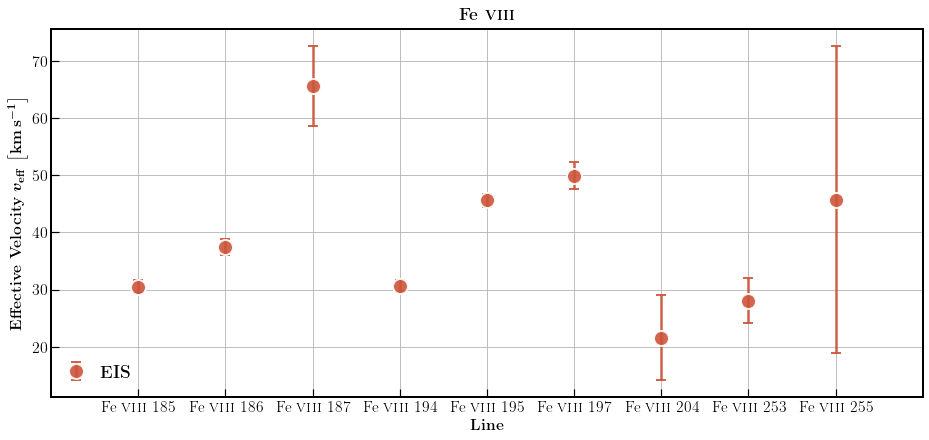

In [9]:
plot_eis_awsom_width(df,"Fe","viii",quality=["a","b"])

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
20  Fe          ix  8  55.85   5.8  191.209      191.206   0.07710   0.00180   
35  Fe          ix  8  55.85   5.8  197.856      197.854   0.08085   0.00035   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
20     0.0331           0.087         0.00090           0.0520       a  NaN   
35     0.0410           0.084         0.00002           0.0467       a  NaN   

    fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  eis_veff_err  
20         0.044089       0.004193  31.167678   48.964329      3.947984  
35         0.050360       0.000690  37.309291   42.496193      0.628055  


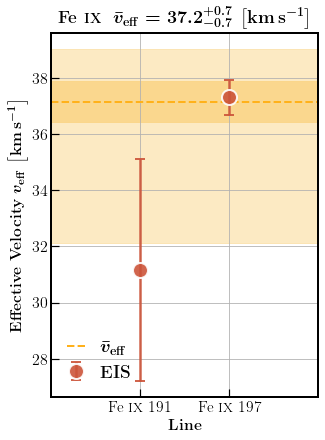

In [30]:
plot_eis_awsom_width(df,"Fe","ix",quality=["a"],plot_mle=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
0   Fe           x  9  55.85   5.9  174.521      174.531   0.07940   0.00150   
2   Fe           x  9  55.85   5.9  177.230      177.240   0.08077   0.00064   
7   Fe           x  9  55.85   5.9  184.533      184.537   0.07900   0.00026   
18  Fe           x  9  55.85   5.9  190.034      190.037   0.08027   0.00048   
25  Fe           x  9  55.85   5.9  193.711      193.715   0.07780   0.00120   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
0      0.0380           0.082         0.00003           0.0434       a  NaN   
2      0.0407           0.083         0.00020           0.0440       a  NaN   
7      0.0371           0.084         0.00010           0.0457       a  NaN   
18     0.0398           0.085         0.00003           0.0481       a  NaN   
25     0.0346           0.084         0.00100           0.0470       a  NaN   

    fwhm_true_cross  fwhm_true_err   eis_vef

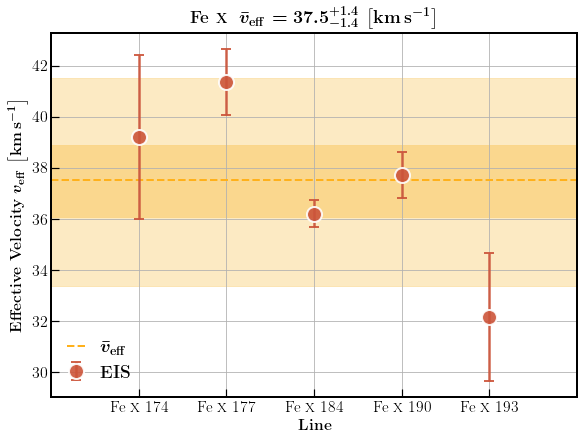

In [11]:
plot_eis_awsom_width(df,"Fe","x",quality=["a"],plot_mle=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
0   Fe           x  9  55.85   5.9  174.521      174.531   0.07940   0.00150   
2   Fe           x  9  55.85   5.9  177.230      177.240   0.08077   0.00064   
4   Fe           x  9  55.85   5.9  182.304      182.307   0.08560   0.00270   
7   Fe           x  9  55.85   5.9  184.533      184.537   0.07900   0.00026   
18  Fe           x  9  55.85   5.9  190.034      190.037   0.08027   0.00048   
25  Fe           x  9  55.85   5.9  193.711      193.715   0.07780   0.00120   
38  Fe           x  9  55.85   5.9  201.572      201.565   0.08410   0.00340   
47  Fe           x  9  55.85   5.9  207.448      207.448   0.07090   0.00180   
66  Fe           x  9  55.85   5.9  266.091      266.049   0.09200   0.01500   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
0      0.0380           0.082         0.00003           0.0434       a   
2      0.0407           0.083         0.00020      

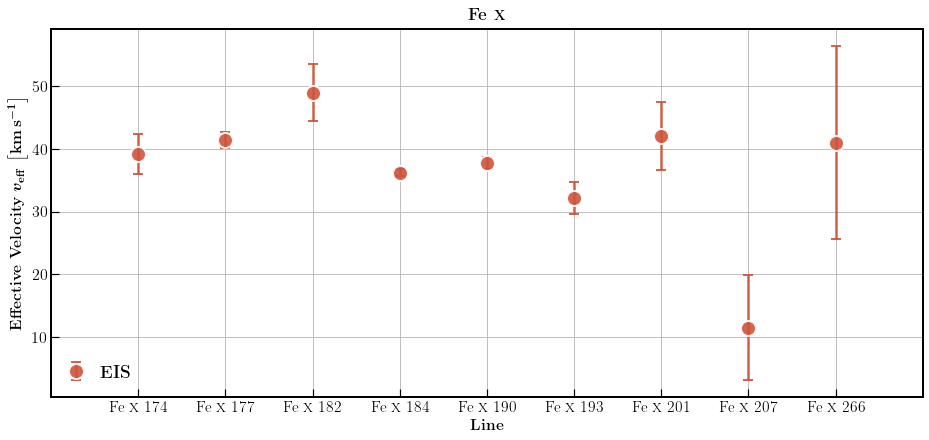

In [12]:
plot_eis_awsom_width(df,"Fe","x",quality=["a","b"],plot_mle=False)

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
3   Fe          xi  10  55.85   6.0  182.163      182.167   0.08020   0.00150   
12  Fe          xi  10  55.85   6.0  188.214      188.216   0.08034   0.00034   
13  Fe          xi  10  55.85   6.0  188.300      188.299   0.08034   0.00034   
23  Fe          xi  10  55.85   6.0  192.626      192.627   0.08170   0.00160   
41  Fe          xi  10  55.85   6.0  202.424      202.424   0.08660   0.00300   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
3      0.0396           0.086         0.00010           0.0503       a  NaN   
12     0.0399           0.087         0.00007           0.0522       a  NaN   
13     0.0399           0.087         0.00007           0.0522       a  NaN   
23     0.0427           0.085         0.00100           0.0488       a  NaN   
41     0.0514           0.089         0.00010           0.0553       a  NaN   

    fwhm_true_cross  fwhm_true_err   e

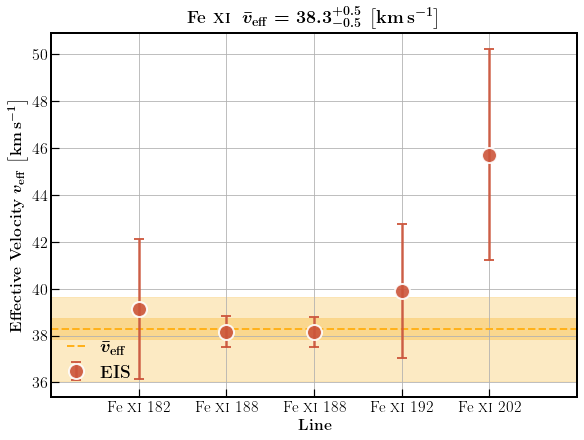

In [13]:
plot_eis_awsom_width(df,"Fe","xi",quality=["a"],plot_mle=True,print_veff=True)

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
3   Fe          xi  10  55.85   6.0  182.163      182.167   0.08020   0.00150   
12  Fe          xi  10  55.85   6.0  188.214      188.216   0.08034   0.00034   
13  Fe          xi  10  55.85   6.0  188.300      188.299   0.08034   0.00034   
16  Fe          xi  10  55.85   6.0  189.721      189.711   0.08600   0.01200   
19  Fe          xi  10  55.85   6.0  190.379      190.382   0.08860   0.00910   
23  Fe          xi  10  55.85   6.0  192.626      192.627   0.08170   0.00160   
39  Fe          xi  10  55.85   6.0  201.732      201.734   0.07680   0.00520   
41  Fe          xi  10  55.85   6.0  202.424      202.424   0.08660   0.00300   
57  Fe          xi  10  55.85   6.0  256.920      256.919   0.08620   0.00400   
58  Fe          xi  10  55.85   6.0  257.762      257.772   0.08800   0.02200   
65  Fe          xi  10  55.85   6.0  264.776      264.772   0.08290   0.00800   

    fwhm_true  fwhm_awsom_f

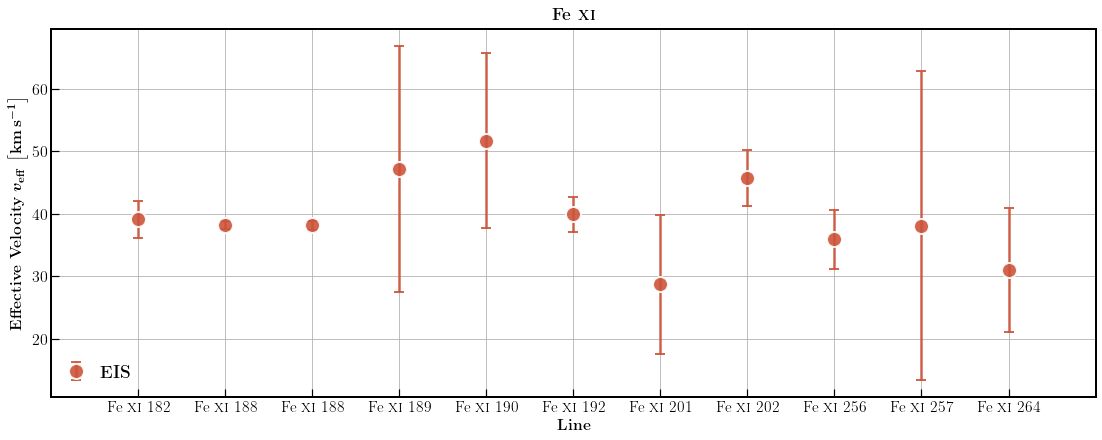

In [14]:
plot_eis_awsom_width(df,"Fe","xi",quality=["a","b"],plot_mle=False)

### Figure 6
<a id='figure6'></a> 

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
22  Fe         xii  11  55.85   6.1  192.394      192.394   0.08130   0.00240   
24  Fe         xii  11  55.85   6.1  193.509      193.509   0.08057   0.00052   
29  Fe         xii  11  55.85   6.1  195.123      195.119   0.08437   0.00051   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
22     0.0419           0.092          0.0003           0.0593       a  NaN   
24     0.0404           0.092          0.0003           0.0594       a  NaN   
29     0.0475           0.093          0.0004           0.0613       a  NaN   

    fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  eis_veff_err  
22         0.051080       0.004657  39.210328   55.493376      4.357869  
24         0.049910       0.001037  37.588775   55.266664      0.964877  
29         0.055837       0.000906  43.830056   56.563841      0.835878  


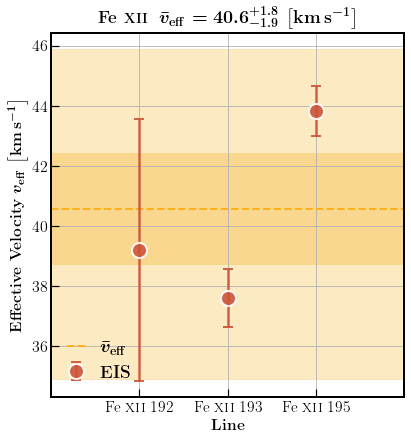

In [15]:
plot_eis_awsom_width(df,"Fe","xii",quality=["a"],plot_mle=True,save_fig=True,plot_awsom=False,
save_fname="../../figs/ms/FeXII_summary.pdf")

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
22  Fe         xii  11  55.85   6.1  192.394      192.394   0.08130   0.00240   
24  Fe         xii  11  55.85   6.1  193.509      193.509   0.08057   0.00052   
29  Fe         xii  11  55.85   6.1  195.123      195.119   0.08437   0.00051   
62  Fe         xii  11  55.85   6.1  259.970      259.973   0.08500   0.01600   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
22     0.0419           0.092          0.0003           0.0593       a  NaN   
24     0.0404           0.092          0.0003           0.0594       a  NaN   
29     0.0475           0.093          0.0004           0.0613       a  NaN   
62     0.0498           0.107          0.0008           0.0813       b  NaN   

    fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  eis_veff_err  
22         0.051080       0.004657  39.210328   55.493376      4.357869  
24         0.049910       0.001037  37.588775   55

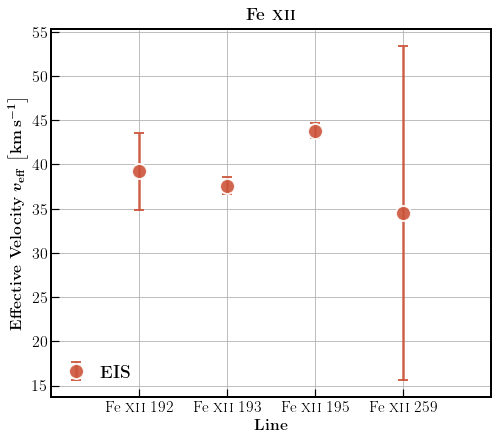

In [16]:
plot_eis_awsom_width(df,"Fe","xii",quality=["a","b"])

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
40  Fe        xiii  12  55.85   6.1  202.051      202.044    0.0822    0.0013   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
40     0.0435           0.098           0.001           0.0691       a  NaN   

    fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  eis_veff_err  
40           0.0525       0.002457  38.763348     61.5758      2.189061  
40    38.763348
dtype: float64
40    2.189061
dtype: float64


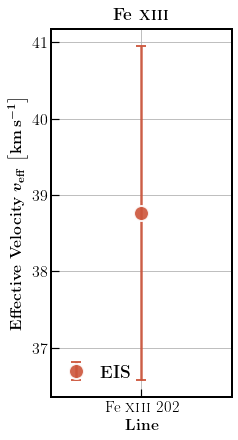

In [17]:
plot_eis_awsom_width(df,"Fe",["xiii"],quality=["a"],print_veff=True)

  ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
6   O          vi  5  15.9994   5.6  184.116      184.117    0.0811    0.0012   

   fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
6     0.0415           0.085           0.001            0.048       a  NaN   

   fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  eis_veff_err  
6         0.050761       0.002345  40.581882    46.93808       2.29318  
6    40.581882
dtype: float64
6    2.29318
dtype: float64


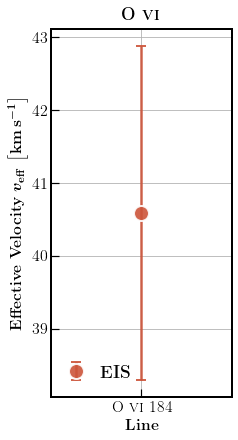

In [18]:
plot_eis_awsom_width(df,"O",["vi"],quality=["a"],print_veff=True)

  ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
5   O          vi  5  15.9994   5.6  183.927      183.937    0.0973    0.0031   
6   O          vi  5  15.9994   5.6  184.116      184.117    0.0811    0.0012   

   fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
5     0.0678           0.086           0.003           0.0499       b  NaN   
6     0.0415           0.085           0.001           0.0480       a  NaN   

   fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  eis_veff_err  
5         0.073937       0.004449  66.364919   48.843798      4.354655  
6         0.050761       0.002345  40.581882   46.938080      2.293180  


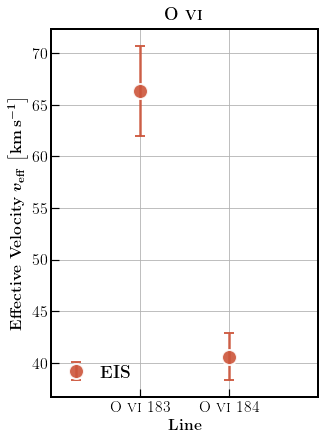

In [19]:
plot_eis_awsom_width(df,"O",["vi"],quality=["a","b"])

   ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
74  Mg         vii  6  24.305   5.8  276.137      276.154    0.0911    0.0032   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
74     0.0593           0.096          0.0001           0.0662       a  NaN   

    fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  eis_veff_err  
74         0.065564       0.004916  38.661734   43.160317      3.205091  
74    38.661734
dtype: float64
74    3.205091
dtype: float64


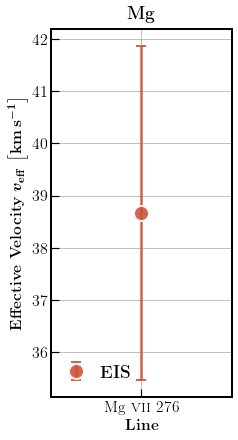

In [20]:
plot_eis_awsom_width(df,"Mg",quality=["a"],print_veff=True)

   ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
68  Mg          vi  5  24.305   5.7  268.982      268.991    0.0880    0.0120   
74  Mg         vii  6  24.305   5.8  276.137      276.154    0.0911    0.0032   
79  Mg         vii  6  24.305   5.8  280.727      280.742    0.0779    0.0073   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
68     0.0542           0.095        0.000008           0.0637       b  NaN   
74     0.0593           0.096        0.000100           0.0662       a  NaN   
79     0.0358           0.097        0.000008           0.0676       b  NaN   

    fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  eis_veff_err  
68         0.061184       0.019483  36.277681   42.636315     13.040819  
74         0.065564       0.004916  38.661734   43.160317      3.205091  
79         0.045474       0.015885  22.959034   43.352813     10.187037  
68    36.277681
74    38.661734
79    22.959034
dtype: float64

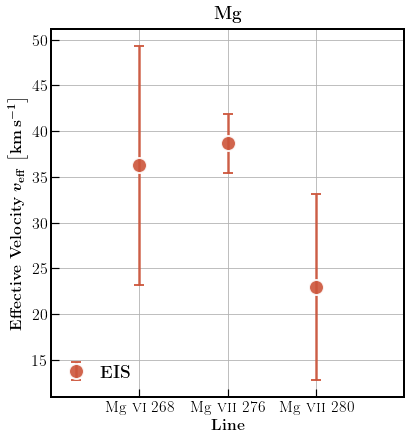

In [21]:
plot_eis_awsom_width(df,"Mg",quality=["a","b"],print_veff=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
60  Si           x  9  28.0855   6.0  258.371      258.374    0.0878   
63  Si           x  9  28.0855   6.0  261.054      261.056    0.0851   

    fwhm_err  fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true  \
60    0.0026     0.0540           0.105          0.0002           0.0777   
63    0.0047     0.0495           0.106          0.0002           0.0790   

   quality desc  fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  \
60       a  NaN         0.060896       0.004227  37.629022   54.143981   
63       a  NaN         0.056934       0.008080  34.138898   54.484302   

    eis_veff_err  
60      2.945800  
63      5.572711  


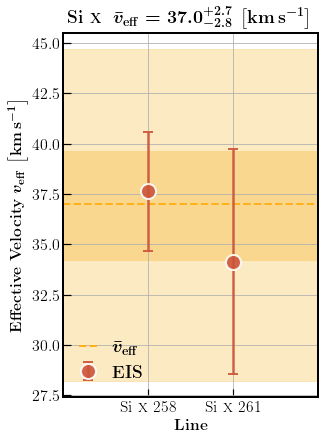

In [22]:
plot_eis_awsom_width(df,"Si","x",quality=["a"],plot_mle=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
71  Si         vii  6  28.0855   5.8  272.642      272.647   0.09120   
72  Si         vii  6  28.0855   5.8  275.363      275.361   0.09166   
73  Si         vii  6  28.0855   5.8  275.678      275.675   0.08960   

    fwhm_err  fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true  \
71   0.00150     0.0594           0.096         0.00002           0.0656   
72   0.00051     0.0601           0.096         0.00002           0.0663   
73   0.00260     0.0569           0.096         0.00002           0.0663   

   quality desc  fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  \
71       a  NaN         0.065703       0.002303  39.225067   43.319266   
72       a  NaN         0.066340       0.000778  39.296151   43.349997   
73       a  NaN         0.063463       0.004094  37.161468   43.300621   

    eis_veff_err  
71      1.520817  
72      0.508570  
73      2.673928  


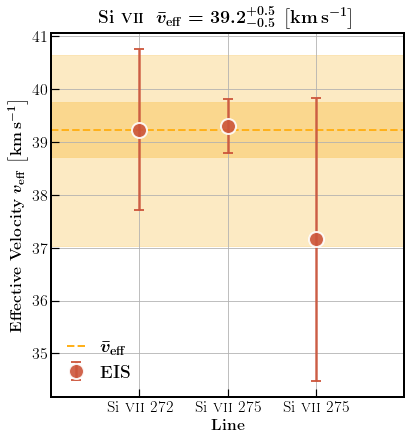

In [23]:
plot_eis_awsom_width(df,"Si","vii",quality=["a"],plot_mle=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
59  Si          ix  8  28.0855   5.9  258.087       258.08     0.086   

    fwhm_err  fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true  \
59     0.018     0.0503           0.095           0.002           0.0645   

   quality                desc  fwhm_true_cross  fwhm_true_err   eis_veff  \
59       b  Fe XI at blue wing          0.05827       0.030775  35.090666   

    awsom_veff  eis_veff_err  
59   44.996977     21.469731  
59    35.090666
dtype: float64
59    21.469731
dtype: float64


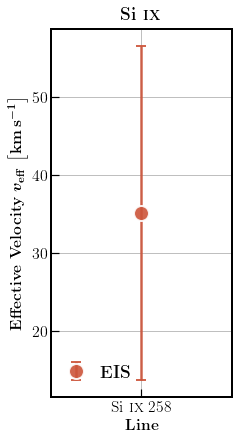

In [24]:
plot_eis_awsom_width(df,"Si","ix",quality=["a","b"],print_veff=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
61   S           x  9  32.06   6.0  259.500      259.496    0.0920    0.0100   
64   S           x  9  32.06   6.0  264.233      264.230    0.0866    0.0058   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
61     0.0605           0.109          0.0030           0.0842       a   
64     0.0520           0.107          0.0005           0.0804       a   

                  desc  fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  \
61  sim bl with Fe XII         0.066809       0.015207  41.976158   58.419710   
64                 NaN         0.059152       0.009659  35.432288   54.783768   

    eis_veff_err  
61     10.550663  
64      6.581705  
61    41.976158
64    35.432288
dtype: float64
61    10.550663
64     6.581705
dtype: float64


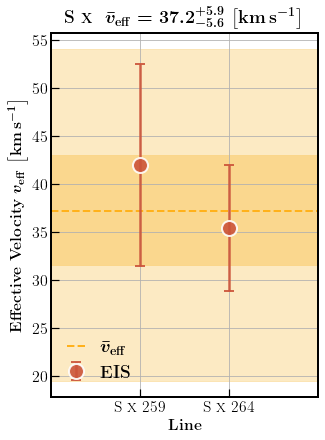

In [25]:
plot_eis_awsom_width(df,"S","x",quality=["a"],plot_mle=True,print_veff=True)

   ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
9   Mn        viii  7  54.938   5.8  185.449      185.463    0.0828    0.0039   
21  Mn          ix  8  54.938   5.9  191.604      191.635    0.0900    0.0040   
27  Mn           x  9  54.938   5.9  194.323      194.299    0.0762    0.0030   
37  Mn          ix  8  54.938   5.9  199.317      199.318    0.0727    0.0080   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
9      0.0447           0.082          0.0001           0.0423       b   
21     0.0569           0.083          0.0005           0.0445       b   
27     0.0306           0.086          0.0005           0.0504       a   
37     0.0208           0.088          0.0020           0.0532       b   

              desc  fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  \
9   bl with Fe VII         0.053435       0.007224  43.393854   41.063982   
21             NaN         0.064027       0.006327  53.458333   41.80

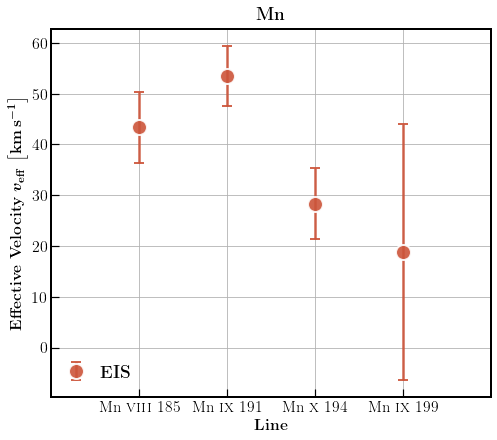

In [26]:
plot_eis_awsom_width(df,"Mn",quality=["a","b"],print_veff=True)

   ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
43  Cr         vii  6  51.996   5.8  202.832      202.825    0.0896    0.0063   
46  Cr        viii  7  51.996   5.8  205.030      205.010    0.0781    0.0023   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
43     0.0563           0.083          0.0004           0.0441       b   
46     0.0352           0.101          0.0020           0.0722       b   

                   desc  fwhm_true_cross  fwhm_true_err   eis_veff  \
43                  NaN         0.063463       0.010026  49.976391   
46  sim bl with Fe XIII         0.045815       0.005103  30.913316   

    awsom_veff  eis_veff_err  
43   39.146693      8.900136  
46   63.407427      4.481662  
43    49.976391
46    30.913316
dtype: float64
43    8.900136
46    4.481662
dtype: float64


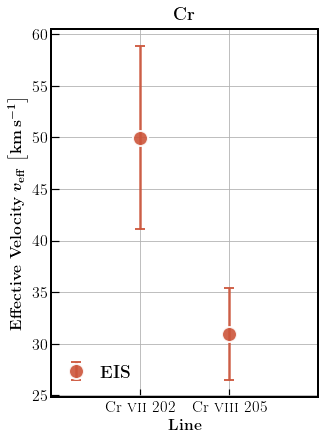

In [27]:
plot_eis_awsom_width(df,"Cr",quality=["a","b"],print_veff=True)

   ion charge_stat   Z     A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
36  Ni          xi  10  58.7   5.9  198.422      198.424    0.0969    0.0082   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
36     0.0673           0.088          0.0004           0.0539       b  NaN   

    fwhm_true_cross  fwhm_true_err   eis_veff  awsom_veff  eis_veff_err  
36          0.07341       0.011807  61.065911   48.907171     10.712883  
36    61.065911
dtype: float64
36    10.712883
dtype: float64


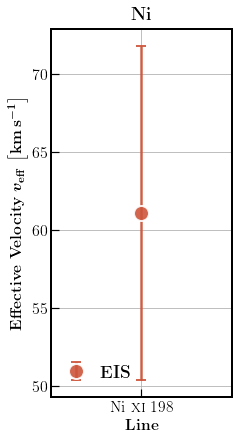

In [28]:
plot_eis_awsom_width(df,"Ni",quality=["a","b"],print_veff=True)